# Laboratorio #5

**Esteban Zambrano - 22119**<br>
**Edwin Ortega - 22305**<br>
**Diego García - 22404**

### Carga de datos

In [16]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("../data")
df = pd.read_csv(DATA_DIR / "train.csv", encoding="utf-8", low_memory=False)

print(df.shape)
print(df.columns.tolist())
print(df.isna().mean().round(4))
df.head()

(7613, 5)
['id', 'keyword', 'location', 'text', 'target']
id          0.0000
keyword     0.0080
location    0.3327
text        0.0000
target      0.0000
dtype: float64


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
# valida que vengan las columnas esperadas
expected = {"id","keyword","location","text","target"}
missing = expected - set(df.columns)
assert not missing, f"Faltan columnas: {missing}"

### Limpieza y preprocesamiento de datos

In [18]:
import re, string, json
import numpy as np
import pandas as pd
from pathlib import Path

KEEP_911 = True
REMOVE_NUMBERS = True
APPLY_STOPWORDS = True

try:
    from nltk.corpus import stopwords
    STOP = set(stopwords.words("english"))
except Exception:
    try:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
        STOP = set(ENGLISH_STOP_WORDS)
    except Exception:
        STOP = set()

if "df" not in globals():
    df = pd.read_csv("data/train.csv")

In [19]:
# Patrones regex y funciones de limpieza

URL_PATTERN     = re.compile(r"http[s]?://\S+|www\.\S+")
HTML_PATTERN    = re.compile(r"<.*?>")
HANDLE_PATTERN  = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#(\w+)")
EMOJI_PATTERN   = re.compile("[" # rangos Unicode de emojis
    "\U0001F600-\U0001F64F"  # emoticonos
    "\U0001F300-\U0001F5FF"  # símbolos
    "\U0001F680-\U0001F6FF"  # transporte/mapas
    "\U0001F1E0-\U0001F1FF"  # banderas
    "]+", flags=re.UNICODE)

def _remove_numbers(text: str) -> str:
    if not REMOVE_NUMBERS:
        return text
    if KEEP_911:
        # elimina números aislados, excepto 911
        return re.sub(r"\b(?!911\b)\d+\b", " ", text)
    # elimina todos los números
    return re.sub(r"\d+", " ", text)

def clean_text_basic(s: str) -> str:
    """
    Pasos: 
      1) minúsculas 
      2) quitar URLs y HTML
      3) quitar @handles y '#', conservando la palabra del hashtag
      4) quitar emojis
      5) quitar números (con opción de conservar 911)
      6) quitar puntuación
      7) colapsar espacios
    """
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)

    x = s.lower()
    x = URL_PATTERN.sub(" ", x)
    x = HTML_PATTERN.sub(" ", x)
    x = HANDLE_PATTERN.sub(" ", x)
    x = HASHTAG_PATTERN.sub(r"\1", x)
    x = EMOJI_PATTERN.sub(" ", x)
    x = _remove_numbers(x)
    x = x.translate(str.maketrans("", "", string.punctuation))
    x = re.sub(r"\s+", " ", x).strip()
    return x

def remove_stopwords(s: str) -> str:
    if not APPLY_STOPWORDS or not STOP:
        return s
    toks = s.split()
    toks = [t for t in toks if t not in STOP]
    return " ".join(toks)

In [20]:
# Aplicar la limpieza y crear clean_text
assert {"text","target"}.issubset(df.columns), "Columnas esperadas no encontradas."

df["clean_text"] = df["text"].map(clean_text_basic).map(remove_stopwords)

# Vista rápida de la limpieza
df[["text", "clean_text"]].head(10)


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy closed directi...
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain causes flash floodin...
7,I'm on top of the hill and I can see a fire in...,im top hill see fire woods
8,There's an emergency evacuation happening now ...,theres emergency evacuation happening building...
9,I'm afraid that the tornado is coming to our a...,im afraid tornado coming area


In [21]:
# Quitar digitos dentro de tokens, preservando '911' como token completo

def strip_digits_preserve_911(text: str) -> str:
    toks = text.split()
    out = []
    for t in toks:
        if t == "911":
            out.append(t)
        else:
            t2 = re.sub(r"\d+", "", t)  # quita dígitos embebidos
            if t2:  # descarta tokens vacíos
                out.append(t2)
    return " ".join(out)

df["clean_text"] = df["clean_text"].map(strip_digits_preserve_911)

# Verificación rápida
rem = df["clean_text"].str.contains(r"\d").sum()
print(f"Filas con dígitos remanentes: {rem}")


Filas con dígitos remanentes: 4


In [22]:
# Reporta filas con dígitos que NO sean el token 911
def has_non911_digits(s: str) -> bool:
    toks = s.split()
    for t in toks:
        if any(ch.isdigit() for ch in t) and t != "911":
            return True
    return False

mask_bad = df["clean_text"].map(has_non911_digits)
print("Filas con dígitos (excluyendo el token '911'):", int(mask_bad.sum()))

# Ver ejemplos si hubiera alguno:
df.loc[mask_bad, ["text","clean_text"]].head(10)


Filas con dígitos (excluyendo el token '911'): 0


,text,clean_text


In [23]:
# Métricas de impacto de la limpieza
stats = {
    "rows": len(df),
    "nulls_pct": df.isna().mean().round(4).to_dict(),
}
lens_before_chars = df["text"].astype(str).str.len().describe().round(2).to_dict()
lens_after_chars  = df["clean_text"].astype(str).str.len().describe().round(2).to_dict()
lens_before_words = df["text"].astype(str).str.split().map(len).describe().round(2).to_dict()
lens_after_words  = df["clean_text"].astype(str).str.split().map(len).describe().round(2).to_dict()

print("Resumen dataset:\n", json.dumps(stats, indent=2))
print("\nLen (caracteres) - antes:\n", json.dumps(lens_before_chars, indent=2))
print("\nLen (caracteres) - después:\n", json.dumps(lens_after_chars, indent=2))
print("\nLen (palabras) - antes:\n", json.dumps(lens_before_words, indent=2))
print("\nLen (palabras) - después:\n", json.dumps(lens_after_words, indent=2))


Resumen dataset:
 {
  "rows": 7613,
  "nulls_pct": {
    "id": 0.0,
    "keyword": 0.008,
    "location": 0.3327,
    "text": 0.0,
    "target": 0.0,
    "clean_text": 0.0
  }
}

Len (caracteres) - antes:
 {
  "count": 7613.0,
  "mean": 101.16,
  "std": 33.85,
  "min": 7.0,
  "25%": 78.0,
  "50%": 107.0,
  "75%": 133.0,
  "max": 157.0
}

Len (caracteres) - después:
 {
  "count": 7613.0,
  "mean": 60.33,
  "std": 24.67,
  "min": 3.0,
  "25%": 42.0,
  "50%": 61.0,
  "75%": 79.0,
  "max": 138.0
}

Len (palabras) - antes:
 {
  "count": 7613.0,
  "mean": 14.9,
  "std": 5.73,
  "min": 1.0,
  "25%": 11.0,
  "50%": 15.0,
  "75%": 19.0,
  "max": 31.0
}

Len (palabras) - después:
 {
  "count": 7613.0,
  "mean": 8.82,
  "std": 3.55,
  "min": 1.0,
  "25%": 6.0,
  "50%": 9.0,
  "75%": 11.0,
  "max": 23.0
}


In [24]:
# Guardar dataset limpio
Path("../data").mkdir(exist_ok=True, parents=True)
df.to_csv("../data/train_clean.csv", index=False)
print("Guardado: ..data/train_clean.csv")

Guardado: ..data/train_clean.csv


| Parámetro / Decisión  | Valor / Descripción                                                                 |
| --------------------- | ----------------------------------------------------------------------------------- |
| KEEP\_911             | `True` → se elimina todo número excepto el token completo `"911"`                   |
| REMOVE\_NUMBERS       | `True` → números eliminados (sueltos o embebidos en palabras)                       |
| APPLY\_STOPWORDS      | `True` → stopwords en inglés eliminadas (NLTK; fallback a scikit-learn si no carga) |
| Minúsculas            | Sí, todo el texto se convierte a minúsculas                                         |
| URLs y HTML           | Eliminados con expresiones regulares                                                |
| @handles              | Eliminados completamente                                                            |
| #hashtags             | Se elimina `#` pero se conserva la palabra (`#wildfire → wildfire`)                 |
| Emojis                | Eliminados (rangos Unicode de emoticones, símbolos, banderas, etc.)                 |
| Signos de puntuación  | Eliminados con `string.punctuation`                                                 |
| Espacios múltiples    | Normalizados a un único espacio                                                     |


### N-gramas por clase

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer

assert {"clean_text","target"}.issubset(df.columns), "Falta 'clean_text' o 'target' en df."

TOPK   = 25      # cuántos términos mostrar
MIN_DF = 3       # ignora términos muy raros
STOP   = "english"  # stopwords para CountVectorizer

In [26]:
# Extraer top n-gramas por clase
def top_terms_by_class(texts, y, ngram=(1,1), topk=20, min_df=3, stop_words="english"):
    vec = CountVectorizer(ngram_range=ngram, min_df=min_df, stop_words=stop_words)
    X = vec.fit_transform(texts)
    terms = np.array(vec.get_feature_names_out())

    classes = sorted(pd.Series(y).dropna().unique().tolist())
    rows = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        if len(idx) == 0:
            continue
        freqs = np.asarray(X[idx].sum(axis=0)).ravel()
        order = freqs.argsort()[::-1][:topk]
        for t, f in zip(terms[order], freqs[order]):
            rows.append({"class": int(cls), "term": t, "freq": int(f)})

    out = pd.DataFrame(rows).sort_values(["class", "freq"], ascending=[True, False])
    return out


In [27]:
# Unigramas
uni_df = top_terms_by_class(
    df["clean_text"].values, df["target"].values,
    ngram=(1,1), topk=TOPK, min_df=MIN_DF, stop_words=STOP
)
display(uni_df.head(2*TOPK))

# Bigramas
bi_df = top_terms_by_class(
    df["clean_text"].values, df["target"].values,
    ngram=(2,2), topk=TOPK, min_df=MIN_DF, stop_words=STOP
)
display(bi_df.head(2*TOPK))

Path("../reports").mkdir(exist_ok=True, parents=True)
uni_df.to_csv("../reports/top_unigrams_by_class.csv", index=False)
bi_df.to_csv("../reports/top_bigrams_by_class.csv", index=False)
print("Guardados:\n  ../reports/top_unigrams_by_class.csv\n  ../reports/top_bigrams_by_class.csv")


,class,term,freq
0,0,like,253
1,0,im,244
2,0,amp,193
3,0,new,170
4,0,dont,141
5,0,body,113
6,0,video,96
7,0,people,90
8,0,love,89
9,0,know,85


,class,term,freq
0,0,cross body,38
1,0,liked video,34
2,0,body bag,27
3,0,body bagging,23
4,0,burning buildings,23
5,0,reddit quarantine,21
6,0,body bags,21
7,0,looks like,21
8,0,content policy,20
9,0,feel like,20


Guardados:
  ../reports/top_unigrams_by_class.csv
  ../reports/top_bigrams_by_class.csv


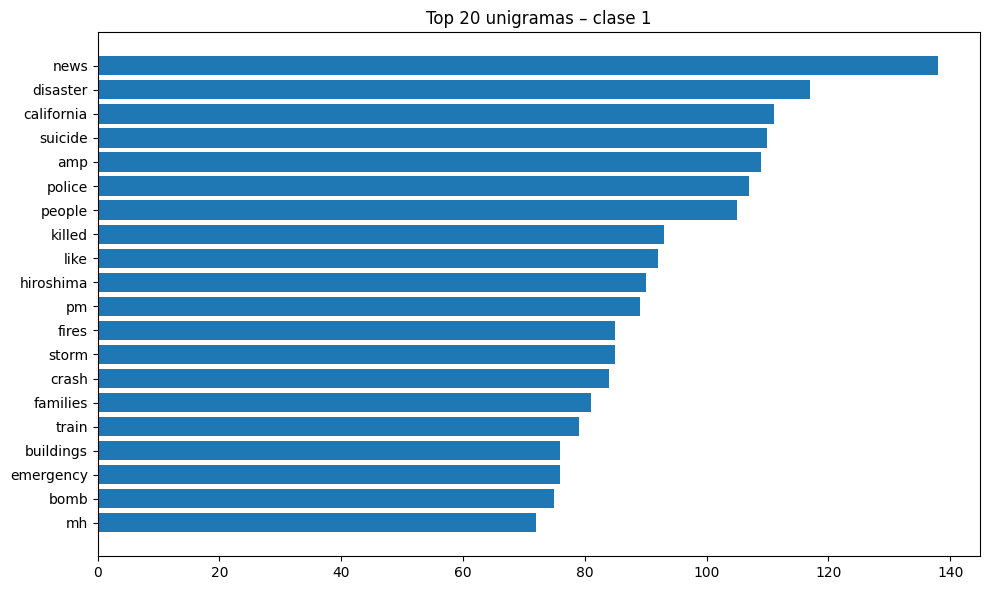

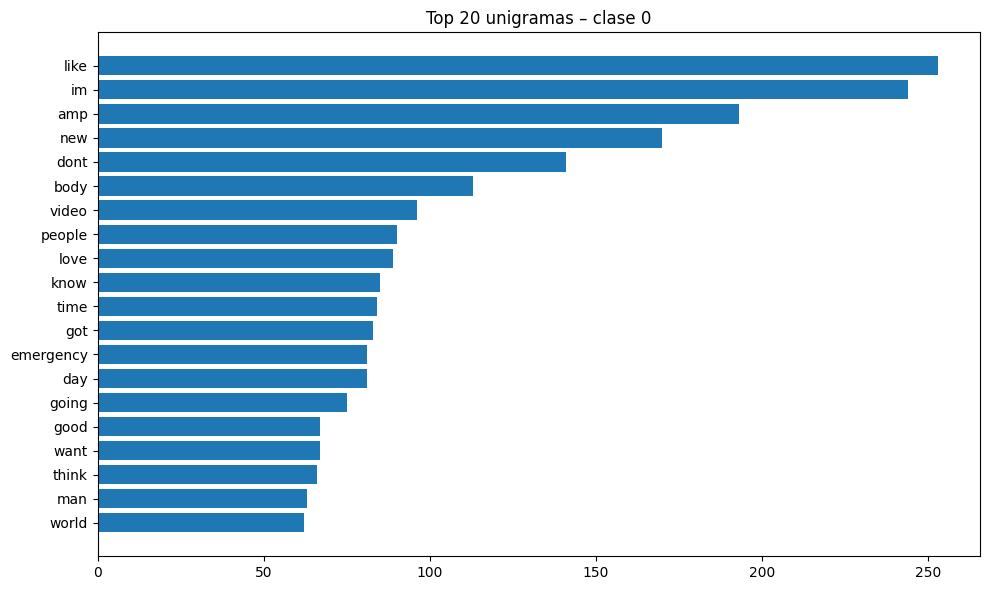

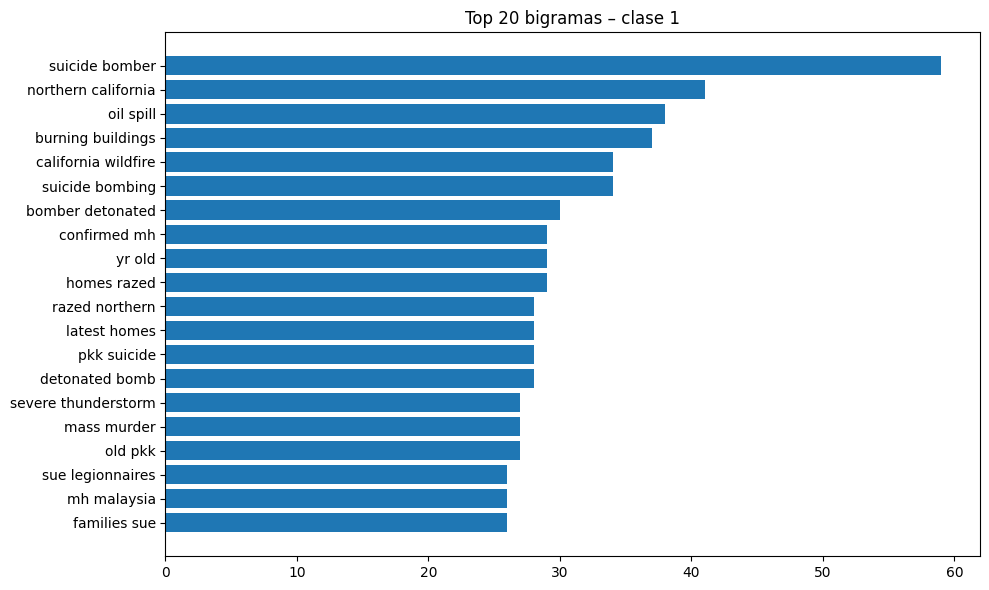

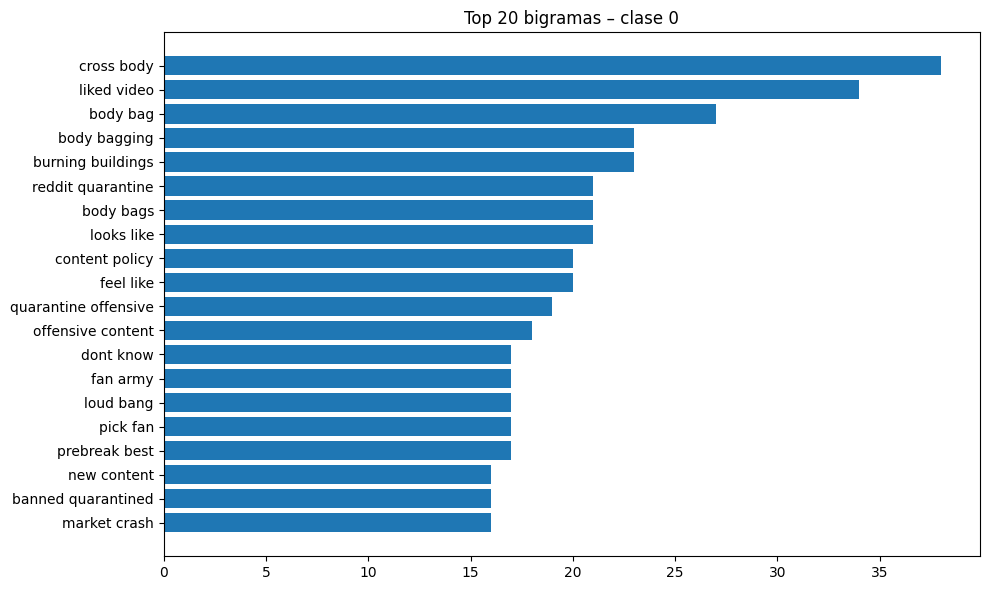

In [28]:
# Barras horizontales por clase
def plot_top_bar(df_terms, cls, title_suffix, topk=20):
    data = df_terms[df_terms["class"]==cls].head(topk).iloc[::-1]
    if data.empty:
        print(f"Clase {cls}: sin términos para graficar.")
        return
    plt.figure(figsize=(10, 6))
    plt.barh(data["term"], data["freq"])  # no especificar colores
    plt.title(f"Top {len(data)} {title_suffix} – clase {cls}")
    plt.tight_layout()
    plt.show()

# Unigramas
plot_top_bar(uni_df, 1, "unigramas", topk=20)
plot_top_bar(uni_df, 0, "unigramas", topk=20)

# Bigramas
plot_top_bar(bi_df,  1, "bigramas",  topk=20)
plot_top_bar(bi_df,  0, "bigramas",  topk=20)


### Análisis exploratorio

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Cargar dataset limpio
df = pd.read_csv("../data/train_clean.csv")

In [ ]:
# ==========================================
# Palabra más repetida en cada categoría
# ==========================================
from collections import Counter

# Separar por clase
disaster_tweets = df[df["target"] == 1]["clean_text"].str.split().sum()
nondisaster_tweets = df[df["target"] == 0]["clean_text"].str.split().sum()

# Contar frecuencia
disaster_counts = Counter(disaster_tweets)
nondisaster_counts = Counter(nondisaster_tweets)

print("Palabra más frecuente en desastres:", disaster_counts.most_common(1))
print("Palabra más frecuente en NO desastres:", nondisaster_counts.most_common(1))


Palabra más frecuente en desastres: [('fire', 178)]
Palabra más frecuente en NO desastres: [('like', 253)]


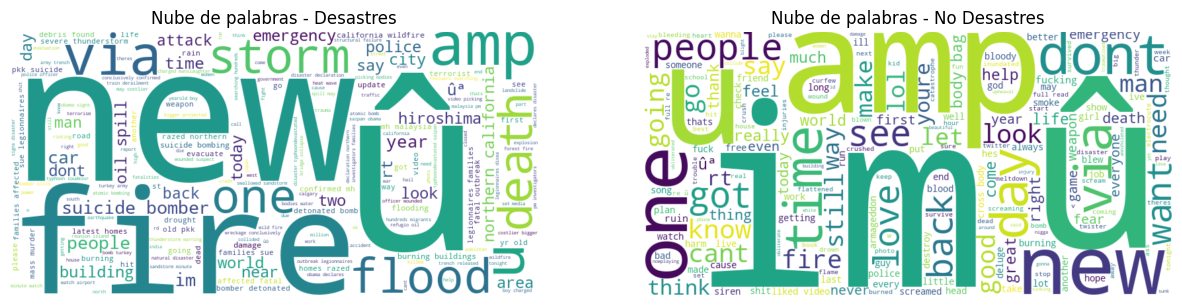

In [ ]:
# ==========================================
# Nubes de palabras por categoría
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(15,7))

# Nube para tweets de desastre
wc_disaster = WordCloud(width=800, height=400, background_color="white").generate(" ".join(disaster_tweets))
axes[0].imshow(wc_disaster, interpolation="bilinear")
axes[0].set_title("Nube de palabras - Desastres")
axes[0].axis("off")

# Nube para tweets de NO desastre
wc_nondisaster = WordCloud(width=800, height=400, background_color="white").generate(" ".join(nondisaster_tweets))
axes[1].imshow(wc_nondisaster, interpolation="bilinear")
axes[1].set_title("Nube de palabras - No Desastres")
axes[1].axis("off")

plt.show()


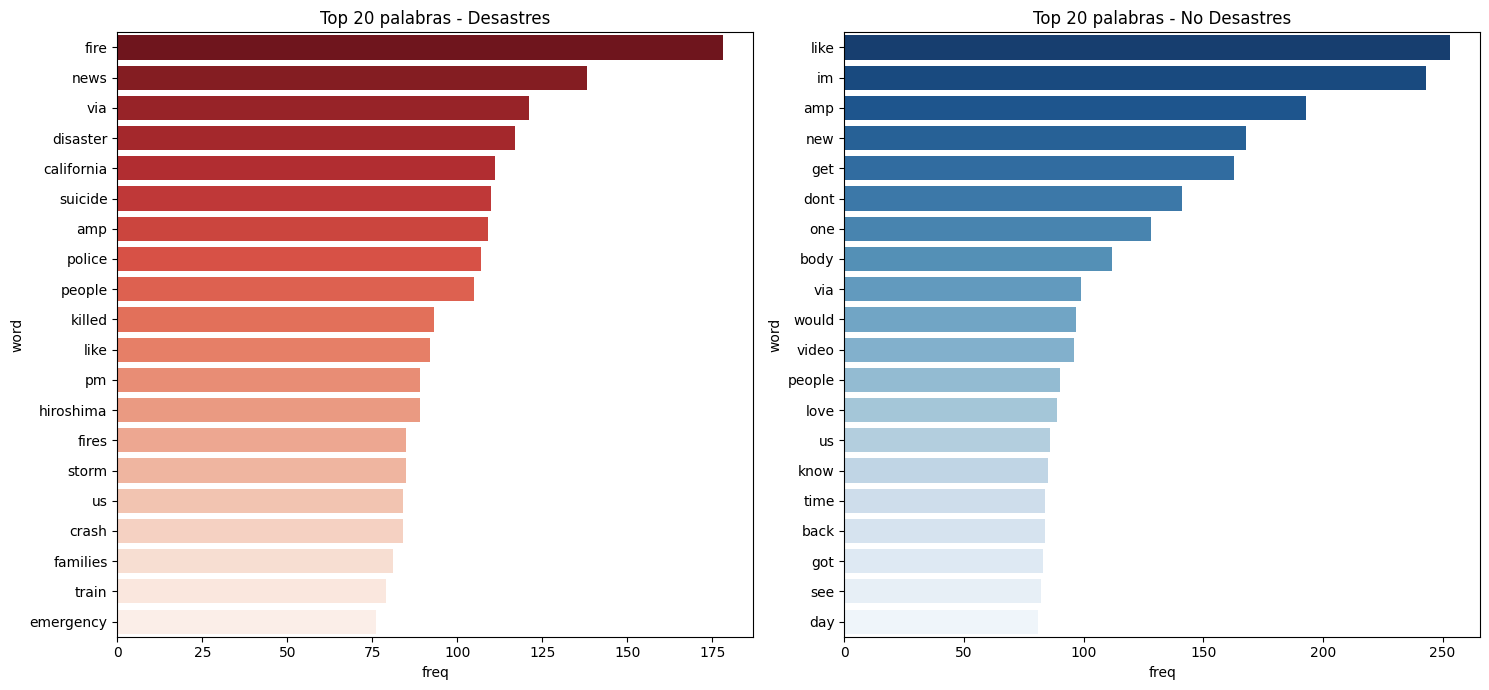

In [35]:
# ==========================================
# Histogramas de palabras más frecuentes
# ==========================================
import seaborn as sns

# Top 20 palabras en cada clase
top_disaster = pd.DataFrame(disaster_counts.most_common(20), columns=["word","freq"])
top_nondisaster = pd.DataFrame(nondisaster_counts.most_common(20), columns=["word","freq"])

fig, axes = plt.subplots(1, 2, figsize=(15,7))

sns.barplot(
    x="freq", y="word", hue="word",
    data=top_disaster, ax=axes[0],
    palette="Reds_r", legend=False
)
axes[0].set_title("Top 20 palabras - Desastres")

sns.barplot(
    x="freq", y="word", hue="word",
    data=top_nondisaster, ax=axes[1],
    palette="Blues_r", legend=False
)
axes[1].set_title("Top 20 palabras - No Desastres")

plt.tight_layout()
plt.show()


In [ ]:
# ==========================================
# Palabras presentes en ambas categorías
# ==========================================
common_words = set(disaster_counts.keys()) & set(nondisaster_counts.keys())

# top 20 palabras comunes más frecuentes
common_counts = []
for word in common_words:
    total_freq = disaster_counts[word] + nondisaster_counts[word]
    common_counts.append((word, disaster_counts[word], nondisaster_counts[word], total_freq))

df_common = pd.DataFrame(common_counts, columns=["word","freq_disaster","freq_nondisaster","total"])
df_common = df_common.sort_values("total", ascending=False).head(20)

print("Palabras comunes en ambas categorías (top 20):")
print(df_common)


Palabras comunes en ambas categorías (top 20):
           word  freq_disaster  freq_nondisaster  total
3565       like             92               253    345
3656        amp            109               193    302
3254         im             56               243    299
3411       fire            178                72    250
2475        get             66               163    229
3514        new             56               168    224
1437        via            121                99    220
2438     people            105                90    195
2188       news            138                57    195
1146        one             65               128    193
3224       dont             50               141    191
2126         us             84                86    170
850       video             69                96    165
1756  emergency             76                81    157
2145   disaster            117                35    152
2378     police            107                33    140
1

En el análisis de las palabras más repetidas dentro de cada categoría se observa una clara diferencia entre el vocabulario de los tweets de desastres y los de no desastres. En los primeros, la palabra más frecuente es “fire”, con un total de 178 apariciones, lo que concuerda con la naturaleza del dataset, ya que los incendios constituyen uno de los desastres más reportados en redes sociales. Por el otro lado, en los tweets de no desastres la palabra que domina es “like”, con 253 apariciones, lo cual refleja un uso más cotidiano, emocional y propio del lenguaje coloquial en redes, sin relación directa con emergencias o situaciones críticas.

Las nubes de palabras permiten visualizar de manera más intuitiva estas diferencias. En la categoría de desastres destacan términos como fire, news, storm, flood, death, police y emergency, todos ellos asociados a hechos objetivos y graves que remiten a catástrofes naturales, accidentes o atentados. Por el contrario, en la categoría de no desastres aparecen con mayor fuerza expresiones como like, im, dont, love, people y time, que corresponden a conversaciones personales, narraciones del día a día o comentarios emocionales.

Al observar los histogramas de las palabras más frecuentes en cada grupo, se confirma nuevamente esta diferencia de patrones. En los tweets de desastres destacan términos directamente vinculados a eventos críticos, como fire, news, disaster, suicide, police, storm y emergency, mientras que en los tweets de no desastres predominan expresiones de carácter subjetivo y narrativo, tales como like, im, dont, love, video y time. La comparación cuantitativa de frecuencias refuerza la idea de que el vocabulario utilizado es un fuerte indicador para la clasificación automática de los mensajes.

Finalmente, el análisis de palabras comunes entre ambas categorías muestra que existe un conjunto compartido, aunque con distribuciones muy diferentes. Palabras como fire, like, im, amp, new, via, people y video aparecen tanto en desastres como en no desastres, pero el peso relativo es lo que marca la diferencia. Por ejemplo, fire es mucho más frecuente en los tweets de desastres, mientras que like e im predominan claramente en los de no desastres. Asimismo, palabras más neutrales como people, new o us aparecen en ambos, aunque sin ser particularmente discriminantes. Este hallazgo sugiere que, aunque existe un vocabulario compartido, la frecuencia relativa de los términos es importante para diferenciarlos.